In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import *

# import tensorflow_addons as tfa
# from keras.utils.vis_utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D


print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.4.0


In [27]:
categories =['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [3]:
base_dir = "F:\\Ml files\\Alzymer detection/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = base_dir + "test/"
train_dir = base_dir + "train/"
work_dir = root_dir + "dataset/"

if os.path.exists(work_dir):
    remove_tree(work_dir)
    

os.mkdir(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))

Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [4]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [5]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


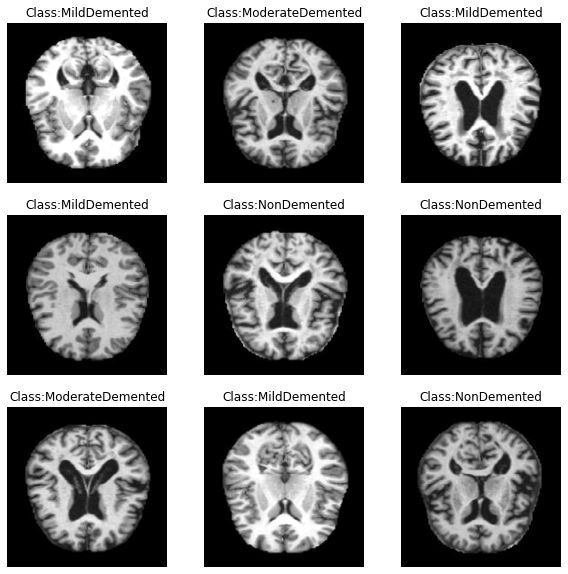

In [6]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [7]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [8]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [9]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [10]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

In [11]:
def conv_block(filters, act='relu'):
    """Defining a Convolutional NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(Conv2D(filters, 3, activation=act, padding='same'))
    block.add(BatchNormalization())
    block.add(MaxPool2D())
    
    return block

In [12]:
def dense_block(units, dropout_rate, act='relu'):
    """Defining a Dense NN block for a Sequential CNN model. """
    
    block = Sequential()
    block.add(Dense(units, activation=act))
    block.add(BatchNormalization())
    block.add(Dropout(dropout_rate))
    
    return block

In [13]:
def construct_model(act='relu'):
    """Constructing a Sequential CNN architecture for performing the classification task. """
    
    model = Sequential([
        Input(shape=(*IMAGE_SIZE, 3)),
        Conv2D(16, 3, activation=act, padding='same'),
        Conv2D(16, 3, activation=act, padding='same'),
        MaxPool2D(),
        conv_block(32),
        conv_block(64),
        conv_block(128),
        Dropout(0.2),
        conv_block(256),
        Dropout(0.2),
        Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        Dense(4, activation='softmax')        
    ], name = "cnn_model")

    return model

In [14]:
#Defining a custom callback function to stop training our model when accuracy goes above 99%

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True
            
my_callback = MyCallback()

#EarlyStopping callback to make sure model is always learning
early_stopping = EarlyStopping(monitor='val_loss', patience=2)
checkpoint_path = 'F:\\Ml files\\Alzymer detection\\model\\kfold-cnn-class_11.h5'
saved_model = ModelCheckpoint(monitor='val_loss', mode='min', filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)

In [15]:
#Defining other parameters for our CNN model

model = construct_model()

METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]

CALLBACKS = [my_callback,saved_model]
    
model.compile(optimizer='adam',
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=METRICS)

model.summary()

Model: "cnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 176, 176, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 176, 176, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 88, 88, 16)        0         
_________________________________________________________________
sequential (Sequential)      (None, 44, 44, 32)        14016     
_________________________________________________________________
sequential_1 (Sequential)    (None, 22, 22, 64)        55680     
_________________________________________________________________
sequential_2 (Sequential)    (None, 11, 11, 128)       221952    
_________________________________________________________________
dropout (Dropout)            (None, 11, 11, 128)       0 

In [16]:
#Fit the training data to the model and validate it using the validation data
EPOCHS = 100

history = model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/100
256/256 [==============================] - 43s 133ms/step - loss: 1.8241 - acc: 0.2961 - auc: 0.5568 - val_loss: 6.8493 - val_acc: 0.2402 - val_auc: 0.5096

Epoch 00001: val_loss improved from inf to 6.84932, saving model to F:\Ml files\Alzymer detection\model\kfold-cnn-class_11.h5
Epoch 2/100
256/256 [==============================] - 33s 130ms/step - loss: 1.0720 - acc: 0.5159 - auc: 0.7971 - val_loss: 2.4382 - val_acc: 0.2524 - val_auc: 0.5441

Epoch 00002: val_loss improved from 6.84932 to 2.43818, saving model to F:\Ml files\Alzymer detection\model\kfold-cnn-class_11.h5
Epoch 3/100
256/256 [==============================] - 33s 130ms/step - loss: 0.7933 - acc: 0.6223 - auc: 0.8828 - val_loss: 1.1239 - val_acc: 0.4800 - val_auc: 0.7767

Epoch 00003: val_loss improved from 2.43818 to 1.12391, saving model to F:\Ml files\Alzymer detection\model\kfold-cnn-class_11.h5
Epoch 4/100
256/256 [==============================] - 34s 133ms/step - loss: 0.7144 - acc: 0.6739 - auc: 0

256/256 [==============================] - 32s 126ms/step - loss: 0.0561 - acc: 0.9818 - auc: 0.9992 - val_loss: 0.4623 - val_acc: 0.8721 - val_auc: 0.9704

Epoch 00035: val_loss did not improve from 0.25794
Epoch 36/100
256/256 [==============================] - 33s 128ms/step - loss: 0.0625 - acc: 0.9818 - auc: 0.9977 - val_loss: 0.2117 - val_acc: 0.9321 - val_auc: 0.9914

Epoch 00036: val_loss improved from 0.25794 to 0.21166, saving model to F:\Ml files\Alzymer detection\model\kfold-cnn-class_11.h5
Epoch 37/100
256/256 [==============================] - 33s 128ms/step - loss: 0.0525 - acc: 0.9854 - auc: 0.9989 - val_loss: 0.4329 - val_acc: 0.8779 - val_auc: 0.9752

Epoch 00037: val_loss did not improve from 0.21166
Epoch 38/100
256/256 [==============================] - 33s 128ms/step - loss: 0.0544 - acc: 0.9838 - auc: 0.9988 - val_loss: 0.2465 - val_acc: 0.9229 - val_auc: 0.9866

Epoch 00038: val_loss did not improve from 0.21166
Epoch 39/100
256/256 [============================

256/256 [==============================] - 32s 126ms/step - loss: 0.0380 - acc: 0.9874 - auc: 0.9995 - val_loss: 0.2106 - val_acc: 0.9463 - val_auc: 0.9882

Epoch 00071: val_loss did not improve from 0.16368
Epoch 72/100
256/256 [==============================] - 32s 125ms/step - loss: 0.0214 - acc: 0.9914 - auc: 0.9997 - val_loss: 0.1944 - val_acc: 0.9526 - val_auc: 0.9889

Epoch 00072: val_loss did not improve from 0.16368
Epoch 73/100
256/256 [==============================] - 40s 157ms/step - loss: 0.0168 - acc: 0.9953 - auc: 0.9996 - val_loss: 0.3330 - val_acc: 0.9238 - val_auc: 0.9805

Epoch 00073: val_loss did not improve from 0.16368
Epoch 74/100
256/256 [==============================] - 32s 125ms/step - loss: 0.0313 - acc: 0.9909 - auc: 0.9991 - val_loss: 0.3026 - val_acc: 0.9243 - val_auc: 0.9818

Epoch 00074: val_loss did not improve from 0.16368
Epoch 75/100
256/256 [==============================] - 34s 133ms/step - loss: 0.0234 - acc: 0.9930 - auc: 0.9997 - val_loss: 0.2

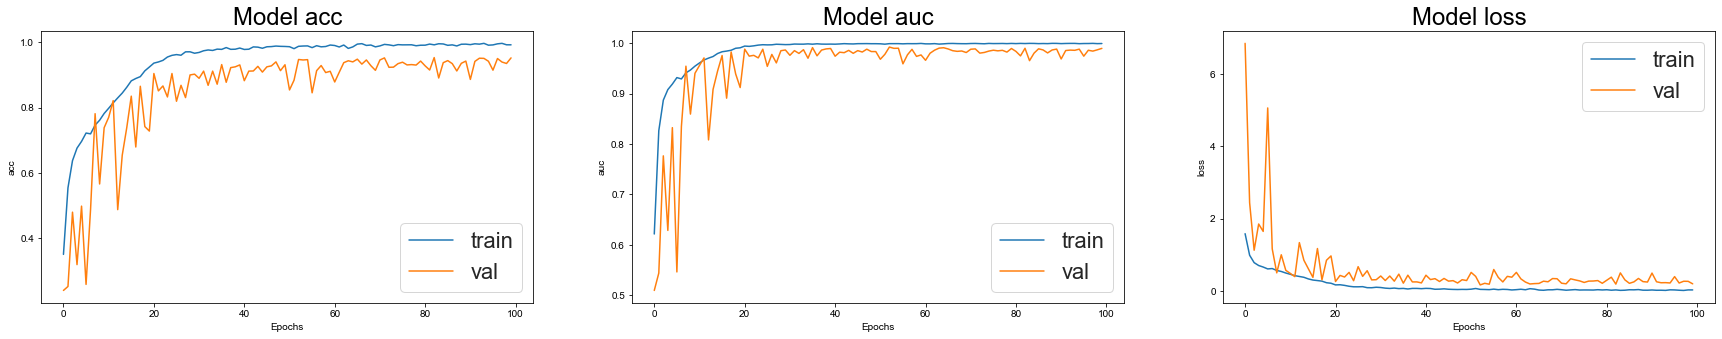

In [17]:
#Plotting the trend of the metrics during training
import seaborn as sns

fig, ax = plt.subplots(1, 3, figsize = (30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    sns.set(font_scale=2)
    sns.set_style('whitegrid')
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [18]:
#Evaluating the model on the data

train_scores = model.evaluate(train_data, train_labels)
val_scores = model.evaluate(val_data, val_labels)
test_scores = model.evaluate(test_data, test_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))
print("Testing Accuracy: %.2f%%"%(test_scores[1] * 100))

80/80 [==============================] - 7s 89ms/step - loss: 0.2138 - acc: 0.9484 - auc: 0.9897
Training Accuracy: 100.00%
Validation Accuracy: 95.26%
Testing Accuracy: 94.84%


In [19]:
#Predicting the test data

pred_labels = model.predict(test_data)

#Print the classification report of the tested data

#Since the labels are softmax arrays, we need to roundoff to have it in the form of 0s and 1s,
#similar to the test_labels
def roundoff(arr):
    """To round off according to the argmax of each predicted label array. """
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.95      0.98      0.97       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.94      0.88      0.91       662
ModerateDemented       0.90      0.93      0.92       624

       micro avg       0.95      0.95      0.95      2560
       macro avg       0.95      0.95      0.95      2560
    weighted avg       0.95      0.95      0.95      2560
     samples avg       0.95      0.95      0.95      2560



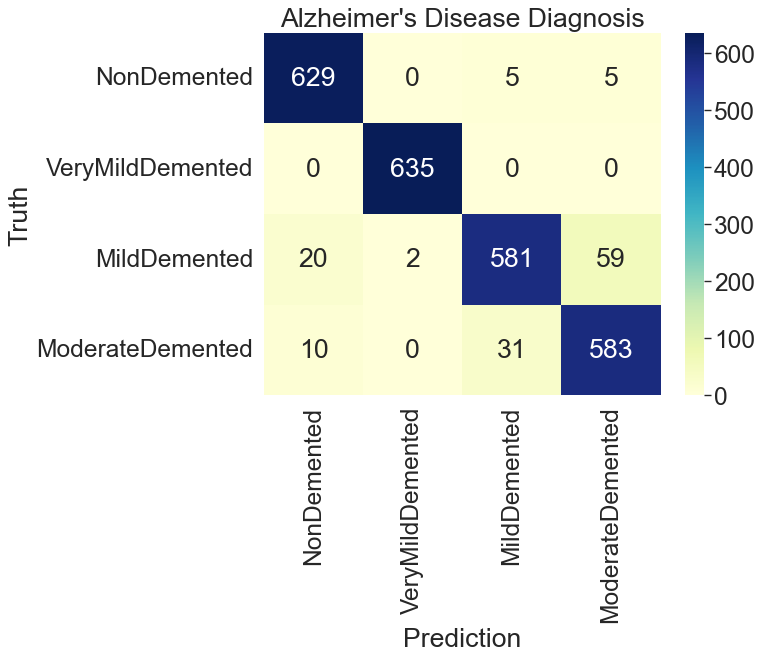

In [20]:
#Plot the confusion matrix to understand the classification in detail

pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='YlGnBu', annot=True, fmt='d', xticklabels=CLASSES, yticklabels=CLASSES)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

ROC AUC score: 0.9659509889409317


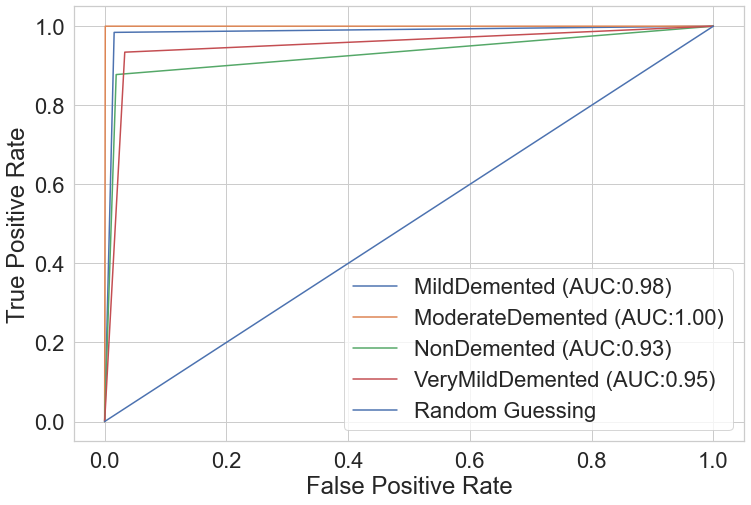

In [31]:
# set plot figure size
from sklearn.preprocessing import LabelBinarizer

fig, c_ax = plt.subplots(1,1, figsize = (12, 8))

# function for scoring roc auc score for multi-class
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(test_labels)
    y_pred = lb.transform(pred_labels)

    for (idx, c_label) in enumerate(categories):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

print('ROC AUC score:', multiclass_roc_auc_score(test_labels,pred_labels))

c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
plt.show()